In [1]:
gps_coords = 46.500458, 8.052669
year = 2020
month = 1
day = 1


In [2]:
from plot_utils import *

date = {'year':year,'month':month,'day':day}

gps_lat, gps_lon = gps_coords

interval = 30
n_intervals = 0

# start_date = datetime.datetime.now().date()

start_date = datetime.date(year = date['year'], month = date['month'], day = date['day'])

td = datetime.timedelta(days = interval)
final_date = start_date + n_intervals * td

metadata_links = {'2m' : '/Users/george-birchenough/Downloads/ch.swisstopo.swissalti3d-fGQ3d2A6.csv' , \
                '0.5m' : 'https://ogd.swisstopo.admin.ch/resources/ch.swisstopo.swissalti3d-3TuKAiHo.csv' }

transformer = Transformer.from_crs( 'epsg:4326', 'epsg:2056' )
swiss_topo_lon, swiss_topo_lat = transformer.transform( gps_lat, gps_lon)

filename = metadata_links['2m']
grid_size = 2
radius = 1
tile_meta_df = get_tile_metadata(filename)
target_tiles = get_targets(swiss_topo_lat, swiss_topo_lon, tile_meta_df, radius)
# plot_tile_corners(target_tiles)

array, blank_array = get_tiles(target_tiles)

observer_pixel, observer_height = get_observer_position(array, blank_array, swiss_topo_lat, swiss_topo_lon )
peaks_df = get_peaks( array, observer_pixel, observer_height, grid_size)


# fig = plot_main(gps_lat, gps_lon, observer_height, peaks_df, start_date, final_date, td )

Opening tile number  0  of  4
Opening tile number  1  of  4
Opening tile number  2  of  4
Opening tile number  3  of  4
Done.
Merging ... 
Done.


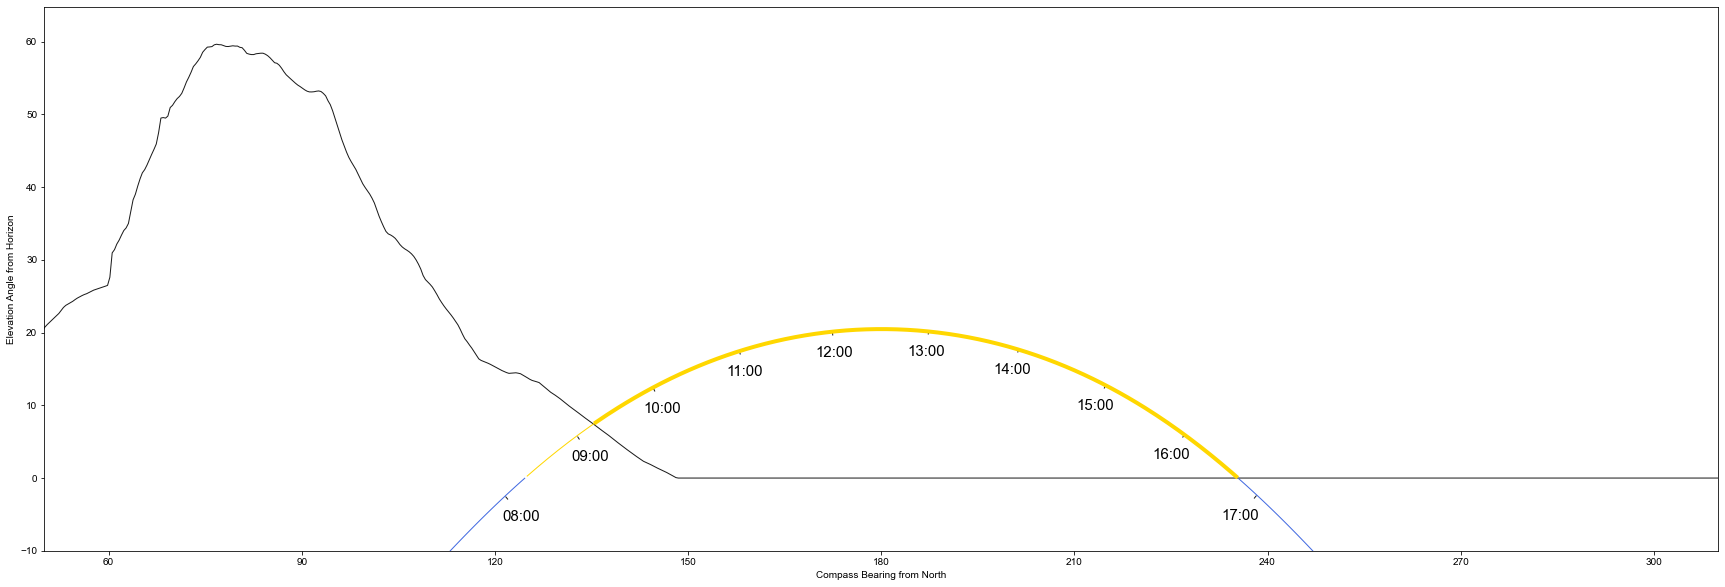

In [9]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.lineplot(x = peaks_df.bearing_deg, y = peaks_df.peak_angle  , color="k", linewidth=1)

hour = np.arange(4, 22)
tdf_ = pd.DataFrame(columns = ['date', 'time', 'azimuth', 'elevation'])
tdf = tdf_.copy()
date = start_date
amdf = pd.DataFrame()
while date <= final_date:
    sun_df = get_sun_path(gps_lat, gps_lon, observer_height, date)
    mdf = get_mtn_sun_times(get_suntimes (peaks_df, sun_df))
    mdf['date'] = date
    # time_df.index = ['azimuth', 'elevation']
    for i in hour:
        ind = mdf.time_since_midnight.sub( i*60 ).abs().idxmin()
        tdf_.loc[i, 'azimuth'] = mdf.loc[ind, 'azimuth']
        tdf_.loc[i, 'elevation'] = mdf.loc[ind, 'elevation'] 
    tdf_['grad'] = np.gradient(tdf_.elevation, tdf_.azimuth)
    tdf_['date'] = date
    tdf_['time'] = hour
    tdf_['midday_elev'] = max(mdf.elevation)
    tdf = pd.concat([tdf, tdf_])
    tdf.reset_index(drop = True, inplace = True)
    amdf = pd.concat([amdf, mdf])
    date = date+td
    plot_sun_paths(mdf)
    plot_timelines(tdf)
    sns.set_theme(style="whitegrid", font_scale = 1)
    ax.set_xticks( np.arange(0,360,30) ) 
    ax.set_xlim(50, 310 )
    ax.set_ylim(-10)
    plt.xlabel( 'Compass Bearing from North')
    plt.ylabel( 'Elevation Angle from Horizon')



In [7]:
import plotly.graph_objects as go
import plotly.io as pio

In [237]:

def make_line_dict(x, y, color = 'black', width = .5):
    return {'line': {'color': color,
            'dash': 'solid',
            'width': width},
            'mode': 'lines',
            'name': '_line0',
            'showlegend' : False,
            'x': x,
            'xaxis': 'x',
            'y': y,
            'yaxis': 'y',
            'type': 'scatter'}

def make_annotation_dict(x, y, text, xshift):
    return  {'text':text, 'x':float(x), 'y':float(y), 
            'xanchor':'center', 
            'yanchor':'middle', 
            # 'height':30,
            'xshift':10*xshift,
            'yshift':-20,
            'showarrow':False
            } 

def get_sun_lines(mdf):
    lines = []
    x = mdf.loc[ mdf.daylight == 'day' ].bearing
    y = mdf.loc[ mdf.daylight == 'day' ].elevation
    lines.append(make_line_dict(x, y, color = 'gold', width = .5))

    # x = mdf.loc[ mdf.daylight == 'day' ].bearing
    # y = mdf.loc[ mdf.daylight == 'day' ].elevation
    # f = sns.lineplot(x = x, y = y , color = 'gold', linewidth=4)

    x = mdf.loc[ mdf.sunlight == 'morning_twighlight' ].azimuth
    y = mdf.loc[ mdf.sunlight == 'morning_twighlight' ].elevation
    # sns.lineplot(x = x, y = y , color = 'royalblue', linewidth=1)
    lines.append(make_line_dict(x, y, color = 'royalblue', width = .5))


    x = mdf.loc[ mdf.sunlight == 'evening_twighlight' ].azimuth
    y = mdf.loc[ mdf.sunlight == 'evening_twighlight' ].elevation
    # sns.lineplot(x = x, y = y , color = 'royalblue', linewidth=1)
    lines.append(make_line_dict(x, y, color = 'royalblue', width = .5))

    for epoch in mdf.epoch.unique():
        if epoch%2 == 1:
            x = mdf.loc[ mdf.epoch == epoch ].azimuth
            y = mdf.loc[ mdf.epoch == epoch ].elevation
            # sns.lineplot(x = x, y = y , color = 'gold', linewidth=4)
            lines.append(make_line_dict(x, y, color = 'gold', width = 2))

    return lines            

peak_lines = make_line_dict(mdf.bearing, mdf.peak_angle, color='black', width = 0.5)

pio.templates.default = "simple_white"

fig = go.Figure(
    data=peak_lines,
    # layout={'annotations':annotations }
)

markers, annotations, shapes = [] , [], []
gdf = tdf.groupby('time')
for hour, df in gdf:
    df = df.sort_values('date').reset_index()
    # print(df.head)
    x = float( df.azimuth )
    y = float( df.elevation )
    text = hour
    grad = float( df.grad )
    fig.add_trace(
        go.Scatter(
            x=[ x, x + 2 * grad],
            y=[ y, y - 5] ,
            line = dict( color="black", width=.1), 
            marker = None,
            mode = 'lines',
            showlegend = False
        )
    )
    # markers.append(make_marker_dict(x,y,hour))
    annotations.append( make_annotation_dict(x, y, text, grad) )

# fig.update_annotations(annotations)
fig.add_traces(
    get_sun_lines(mdf)
)

fig.update_layout( 
    annotations = annotations,
    xaxis = dict(
        tickmode = 'array',
        tickvals = [45.0, 67.5, 90.0, 112.5, 135.0, 157.5, 180.0, 202.5, 225.0, 247.5, 270.0] ,
        ticktext = ['NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W'] ),
    yaxis = dict(
        range = [-10, 80]
    ) )
# fig.add_trace(go.Scatter(lines[1]))
# fig.add_annotation(  annotations[0] )
# fig.update_layout(showlegend=False)
# fig.add_annotation( annotations[0])


In [236]:
[i for i in np.arange(45, 271, 45/2)]

[45.0, 67.5, 90.0, 112.5, 135.0, 157.5, 180.0, 202.5, 225.0, 247.5, 270.0]

In [182]:
annotations[0]

{'text': 4,
 'x': 79.18714064022711,
 'y': -42.195530553060884,
 'xanchor': 'center',
 'yanchor': 'top',
 'height': 30,
 'xshift': 8.8690012314647,
 'showarrow': False}

In [176]:
def make_marker_dict(x, y, text):
    return {'marker': {'color': 'black',
            'line': {'color': 'rgba(25,25,25,1.0)', 'width': 1.0},
            'size': 6.0,\
            'symbol': 'circle'},
            'mode': 'markers',
            'x': x,
            'xaxis': 'x',
            'y': y,
            'yaxis': 'y',
            'showlegend' : False,
            # 'text' : text,
            'type': 'scatter'}


def make_annotation_dict(x, y, text, xshift):
    return  {'text':text, 'x':float(x), 'y':float(y), 
            'xanchor':'center', 
            'yanchor':'top', 
            'height':30,
            'xshift':10*xshift,
            'showarrow':False
            } 

def make_shape_dict(grad):
    return go.layout.Shape( {'type':"line",
            'x0':0, 
            'y0':0, 
            'x1':10*grad, 
            'y1':-10,
            'line':dict( color="LightSeaGreen", width=4) }  )

markers, annotations, shapes = [] , [], []
gdf = tdf.groupby('time')
for hour, df in gdf:
    df = df.sort_values('date').reset_index()
    # print(df.head)
    x = np.array( df.azimuth )
    y = np.array( df.elevation)
    text = hour
    grad = float( df.grad )
    fig.add_trace(
        go.Scatter(mode='lines',
            x=[ x, x + 10 * grad],
            y=[ y, y - 10] ,
            showlegend = False
        )
    )
    # markers.append(make_marker_dict(x,y,hour))
    annotations.append( make_annotation_dict(x, y, text, grad) )

    # 'xshift':grad, 'yshift':-1 } )
    fig
